In [9]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.datasets import cifar100
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [2]:
# Zaladowanie danych z cifar100
(x_training, _), (x_test, _) = cifar100.load_data()

x_training = x_training.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# Zamiana danych treningowych na skalę szarości
x_training_gray = [cv2.cvtColor(x, cv2.COLOR_RGB2GRAY) for x in x_training]
x_training_gray = np.array(x_training_gray).reshape(-1, 32, 32, 1)

# Zamiana danych testowych na skalę szarości
x_test_gray = [cv2.cvtColor(x, cv2.COLOR_RGB2GRAY) for x in x_test]
x_test_gray = np.array(x_test_gray).reshape(-1, 32, 32, 1)



In [18]:
# Definiowane callback
reduce_learning_rate = ReduceLROnPlateau(factor=0.5, patience=3, min_lr=1e-6, verbose=1)

# Definiowane Autoenkodera
input_img = Input(shape=(None, None, 1))

# Enkoder
x = Conv2D(64, kernel_size=3, strides=2, activation='relu', padding='same')(input_img)
x = BatchNormalization()(x)
x = Conv2D(128, kernel_size=3, strides=2, activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(256, kernel_size=3, strides=2, activation='relu', padding='same')(x)
x = BatchNormalization()(x)

# Dekoder
x = Conv2DTranspose(filters=64, kernel_size=3, strides=2, activation='relu', padding='same')(x)
x = Conv2DTranspose(filters=128, kernel_size=3, strides=2, activation='relu', padding='same')(x)
x = Conv2DTranspose(filters=256, kernel_size=3, strides=2, activation='relu', padding='same')(x)
decoded = Conv2D(filters=3, kernel_size=3, activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer=Adam(learning_rate=0.005), loss='mse')

autoencoder.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, None, None, 1)]   0         
                                                                 
 conv2d_15 (Conv2D)          (None, None, None, 64)    640       
                                                                 
 batch_normalization_12 (Bat  (None, None, None, 64)   256       
 chNormalization)                                                
                                                                 
 conv2d_16 (Conv2D)          (None, None, None, 128)   73856     
                                                                 
 batch_normalization_13 (Bat  (None, None, None, 128)  512       
 chNormalization)                                                
                                                                 
 conv2d_17 (Conv2D)          (None, None, None, 256)   2951

In [19]:
# Trenowanie
history = autoencoder.fit(x_training_gray, x_training, epochs=30, batch_size=128, shuffle=True, validation_data=(x_test_gray, x_test), callbacks=[reduce_learning_rate])

Epoch 1/30
391/391 [==============================] - 14s 35ms/step - loss: 0.0156 - val_loss: 0.0235 - lr: 0.0050
Epoch 2/30
391/391 [==============================] - 13s 34ms/step - loss: 0.0110 - val_loss: 0.0186 - lr: 0.0050
Epoch 3/30
391/391 [==============================] - 13s 34ms/step - loss: 0.0101 - val_loss: 0.0104 - lr: 0.0050
Epoch 4/30
391/391 [==============================] - 13s 34ms/step - loss: 0.0098 - val_loss: 0.0132 - lr: 0.0050
Epoch 5/30
391/391 [==============================] - 13s 34ms/step - loss: 0.0096 - val_loss: 0.0099 - lr: 0.0050
Epoch 6/30
391/391 [==============================] - 13s 34ms/step - loss: 0.0094 - val_loss: 0.0098 - lr: 0.0050
Epoch 7/30
391/391 [==============================] - 13s 34ms/step - loss: 0.0092 - val_loss: 0.0092 - lr: 0.0050
Epoch 8/30
391/391 [==============================] - 13s 34ms/step - loss: 0.0091 - val_loss: 0.0092 - lr: 0.0050
Epoch 9/30
391/391 [==============================] - 13s 34ms/step - loss: 0.00

In [29]:
#Funkcja przedstawiajaca proces treningu
def visualise_training(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    lr = history.history['lr']  # Dodane lr

    # Stwórz wykres
    plt.figure(figsize=(12, 6))

    # Krzywa straty
    plt.subplot(1, 2, 1)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Krzywa learning rate
    plt.subplot(1, 2, 2)
    plt.plot(lr, label='Learning Rate', color='green')  # Dodane lr
    plt.title('Learning Rate Over Epochs')  # Dodane lr
    plt.xlabel('Epoch')  # Dodane lr
    plt.ylabel('Learning Rate')  # Dodane lr
    plt.legend()  # Dodane lr

    # Wyświetl wykresy
    plt.tight_layout()
    plt.show()

# Funkcja porownujaca wyniki
def visualise_results(number_of_photos, input_photos, gray_photos, output_photos):
    plt.figure(figsize=(20, 6))

    for idx in range(number_of_photos):

        # Wyswietlanie orygianlnych obrazow
        ax = plt.subplot(3, number_of_photos, idx + 1)
        plt.imshow(input_photos[idx])
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # Wyswietlanie obrazow w skali szarosci
        ax = plt.subplot(3, number_of_photos, idx + number_of_photos + 1)
        plt.imshow(gray_photos[idx].reshape(32, 32), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # Wyświetlenie obrazu przetworzonego przez autoenkoder
        ax = plt.subplot(3, number_of_photos, idx + 2 * number_of_photos + 1)
        plt.imshow(output_photos[idx])
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()

313/313 [==============================] - 2s 5ms/step


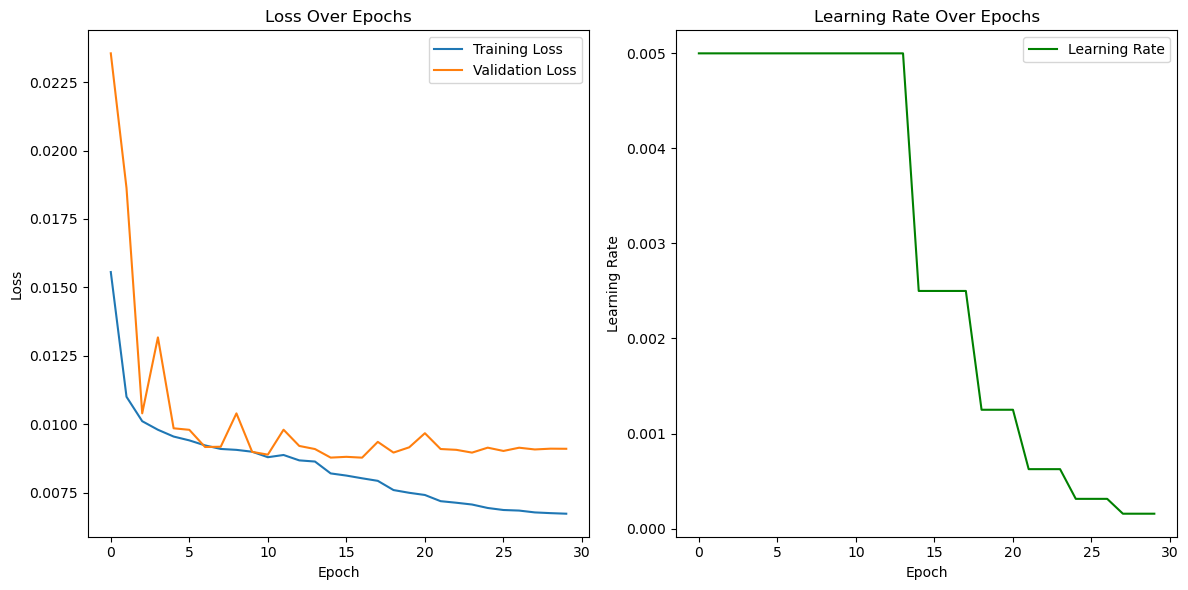

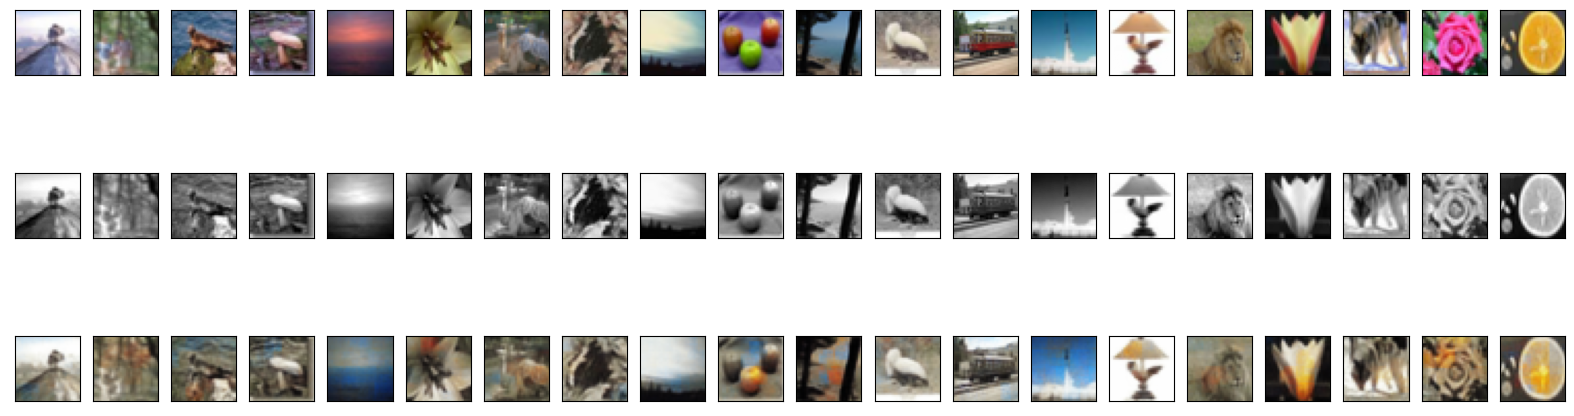

In [30]:
predicted_images = autoencoder.predict(x_test_gray)

visualise_training(history)
visualise_results(20, x_test, x_test_gray, predicted_images)

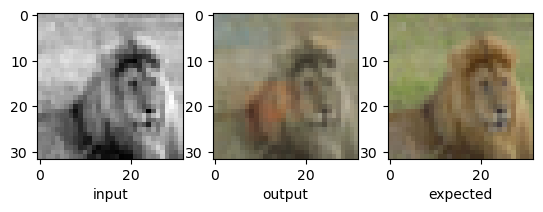

In [27]:
# Pomocnicza funkcja
def plot_result(x, y, Y):
  fig, (ax1, ax2, ax3) = plt.subplots(ncols=3)
  ax1.imshow(y, cmap='gray')
  ax2.imshow(Y)
  ax3.imshow(x)
  ax1.set_xlabel('input')
  ax2.set_xlabel('output')
  ax3.set_xlabel('expected')
  
def plot_test_result(index):
  plot_result(x_test[index], x_test_gray[index], predicted_images[index])

plot_test_result(15)

1/1 [==============================] - 0s 194ms/step


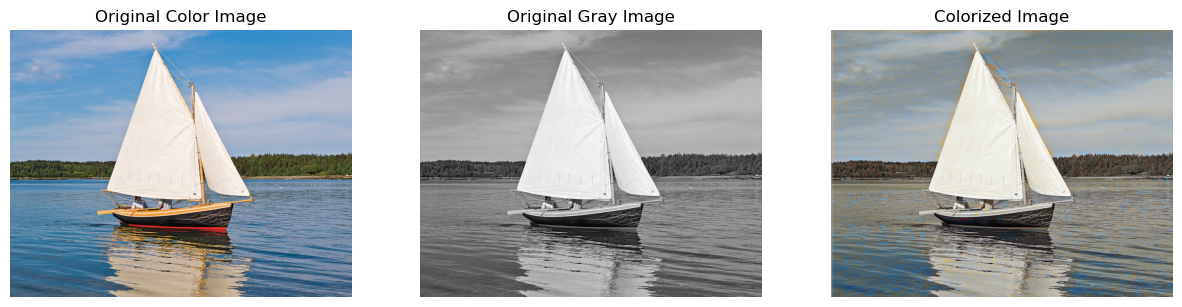

In [35]:
# Funkcja do zaladowania i przetworzenia przez model obrazu o dowolnej wielkosci
def load_and_display_image(file_path, model, display_size=(15, 15)):
    # Ładowanie obrazu
    original_color = cv2.imread(file_path)
    original_color = cv2.cvtColor(original_color, cv2.COLOR_BGR2RGB)
    original_gray = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)

    # Przygotowanie obrazu do przetwarzania przez model
    input_image = np.expand_dims(original_gray, axis=-1) / 255.0  # Normalizacja i dodanie wymiaru kanału
    input_image = np.expand_dims(input_image, axis=0)  # Dodanie wymiaru batch

    # Generowanie kolorowego obrazu
    colorized = model.predict(input_image)
    colorized = np.squeeze(colorized)  # Usunięcie niepotrzebnych wymiarów

    plt.figure(figsize=display_size)

    #Wyświetlanie oryginalnego obrazu w kolorze
    plt.subplot(1, 3, 1)
    plt.imshow(original_color)
    plt.title('Original Color Image')
    plt.axis('off')

    # Wyświetlanie oryginalnego obrazu w skali szarości
    plt.subplot(1, 3, 2)
    plt.imshow(original_gray, cmap='gray')
    plt.title('Original Gray Image')
    plt.axis('off')

    # Wyświetlanie kolorowanego obrazu
    plt.subplot(1, 3, 3)
    plt.imshow(colorized)
    plt.title('Colorized Image')
    plt.axis('off')

    plt.show()
    
load_and_display_image('boat.jpg', autoencoder)